## **Implementation of LSTM-MSNet on M4 forecasting data**

Paper Reference: https://arxiv.org/pdf/1909.04293.pdf

In [ ]:
#Upload the kaggle.json file to directly use the kaggle dataset (provided on kaggle)
from google.colab import files
files.upload()

In [ ]:
#After running this cell if colab notebook shows an error, then restart the kernel and skip this cell in the next run
!pip install --upgrade statsmodels

     |████████████████████████████████| 9.5MB 2.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#API link of the dataset for downloading the data in zip format
!kaggle datasets download -d yogesh94/m4-forecasting-competition-dataset

 82% 65.0M/79.6M [00:02<00:00, 26.2MB/s]
100% 79.6M/79.6M [00:02<00:00, 36.0MB/s]


In [ ]:
#Extraction of files
from zipfile import ZipFile
file_name = "m4-forecasting-competition-dataset.zip"

with ZipFile(file_name, "r") as zip:
  zip.extractall()

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(15, 5)})

In [ ]:
dfm = pd.read_csv('Hourly-train.csv')
dfm_test = pd.read_csv('Hourly-test.csv')

Curve in the following code cell shows the number of Nan Values in each column

Out of 961 columns, there are 700 columns without Nan value.


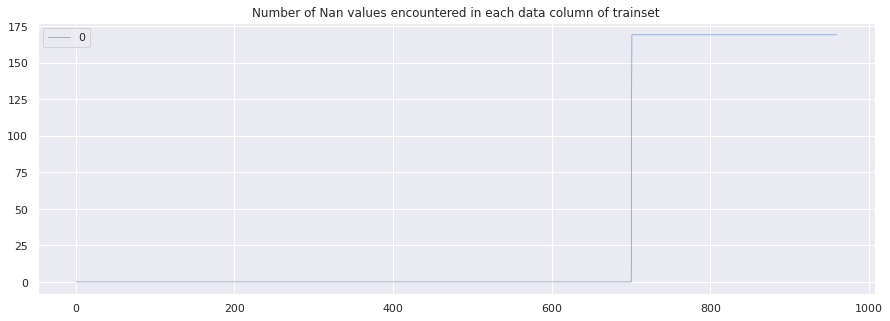

In [ ]:
count = 0
for i in range(1,len(dfm.columns)):
  if dfm.isna().sum()[i] == 0:
    count+=1
  else:
    continue
print("Out of", str(len(dfm.isna().sum())), "columns, there are", str(count), "columns without Nan value.")

t = np.linspace(1,len(dfm.columns),len(dfm.columns))
aa = []
for i in range(1,len(dfm.columns)):
    a = dfm["V"+str(i)].isnull().sum().sum()  
    aa.append(a)
pd.DataFrame(aa).plot(linewidth=0.5,title= "Number of Nan values encountered in each data column of trainset");

In [ ]:
#Train data without Nan values
dfm2 = dfm.dropna(axis = 1)
dfm_test2 = dfm_test.dropna(axis = 1)

In [ ]:
#Train data and test data without V1 
df_tr_m = dfm2.drop(['V1'], axis = 1) 
df_test_m = dfm_test2.drop(['V1'], axis = 1)
df_test_m_final = dfm_test2.drop(['V1'], axis = 1)

In [ ]:
df1 = df_tr_m.reset_index()["V3"]
#df1.max()

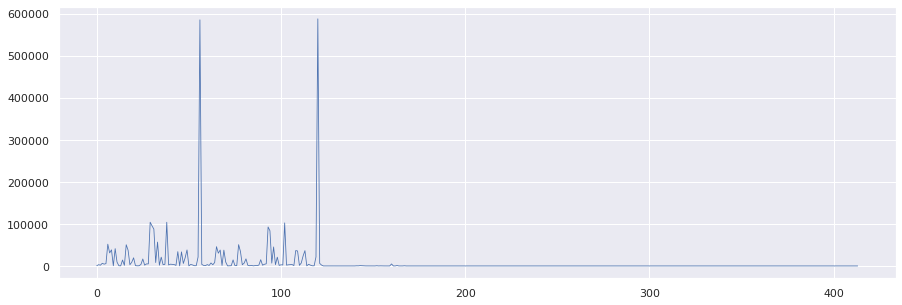

In [ ]:
#Plotting a data series from the given data
df1.plot(linewidth=0.8)

### Time Series Pre-processing

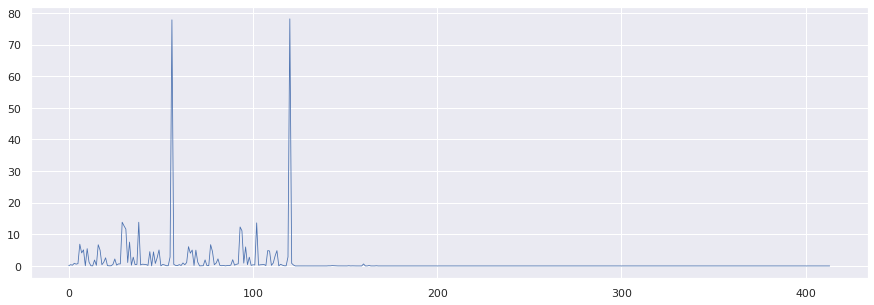

In [ ]:
#Normalization of a series and plotting of the data after normalization
df2 = df1/((1/df1.shape[0])*(df1.sum()))
df2.plot(linewidth=0.8)

In [ ]:
#df3 = pd.DataFrame(data)
#df3

Now implement on whole data and create a data set

In [ ]:
#Normalization of all data (train data as well as test data)
for i in range(2,df_tr_m.shape[1]+2):
    df_tr_m["V"+str(i)] = df_tr_m["V"+str(i)]/((1/df1.shape[0])*(df_tr_m["V"+str(i)].sum()))

for i in range(2,df_test_m.shape[1]+2):
    df_test_m["V"+str(i)] = df_test_m["V"+str(i)]/((1/df1.shape[0])*(df_test_m["V"+str(i)].sum()))

#df_tr_m
#df_test_m

In [ ]:
#Variance Stabilization of all the train data
for i in range(2,df_tr_m.shape[1]+2):
    for j in range(df_tr_m.shape[0]):
        if df_tr_m['V'+str(i)][j] > 0:
            df_tr_m['V'+str(i)][j] = np.log10(df_tr_m['V'+str(i)][j])
        else:
            df_tr_m['V'+str(i)][j] = np.log10((df_tr_m['V'+str(i)][j]) + 1)

#Variance Stabilization of all the test data
for i in range(2,df_test_m.shape[1]+2):
    for j in range(df_test_m.shape[0]):
        if df_test_m['V'+str(i)][j] > 0:
            df_test_m['V'+str(i)][j] = np.log10(df_test_m['V'+str(i)][j])
        else:
            df_test_m['V'+str(i)][j] = np.log10((df_test_m['V'+str(i)][j]) + 1)

In the following cell we have plotted a series from the whole dataset and we can see the difference in data before and after Variance Stabilization. 

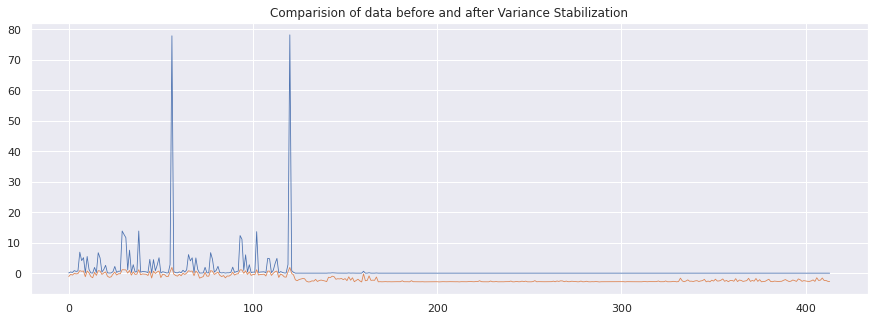

In [ ]:
df2.plot(linewidth=0.8)
df_tr_m["V3"].plot(linewidth=0.8, title = "Comparision of data before and after Variance Stabilization")

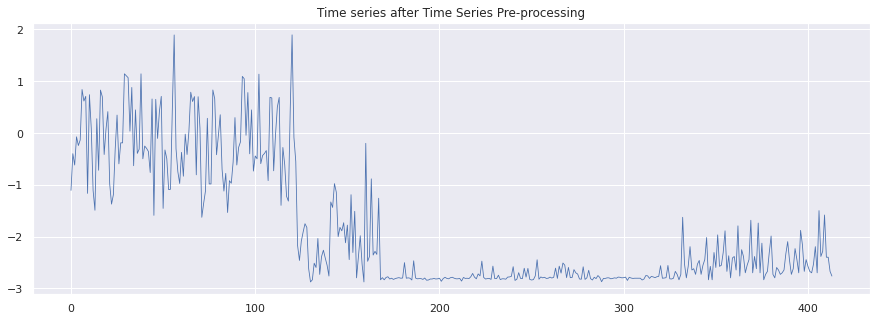

In [ ]:
#This is how our time series looks after Time Series Pre-processing.
df_tr_m["V3"].plot(linewidth = 0.8, title = "Time series after Time Series Pre-processing")

Moving Window Transformation

In [ ]:
def create_dataset(data_column, m, n):
    input_X, output_Y = [], []
    for i in range(len(data_column) -m -n):
        a = data_column[i:i+m, 0]
        input_X.append(a)
        output_Y.append(data_column[i + m : i + m + n, 0])
    return np.array(input_X), np.array(output_Y)

In [ ]:
#Creating Input and Output data of size m samples and m samples for both train and test data
m = 400  #350
n = 13  #25
inputd = []
outputd = []
for i in range(2,len(df_tr_m.columns)+2):
    train_data = np.array(df_tr_m["V"+str(i)])
    train_data = train_data.reshape(len(train_data),1)
    X_training, y_training = create_dataset(train_data, m, n)
    for j in range(X_training.shape[0]):
        inputd.append(X_training[j])
        outputd.append(y_training[j])
inputd = np.array(inputd)
outputd = np.array(outputd)


inputd_test = []
outputd_test = []
for i in range(2,len(df_test_m.columns)+2):
    test_data = np.array(df_test_m["V"+str(i)])
    test_data = test_data.reshape(len(test_data),1)
    X_testing, y_testing = create_dataset(test_data, m, n)
    for j in range(X_testing.shape[0]):
        inputd_test.append(X_testing[j])
        outputd_test.append(y_testing[j])
inputd_test = np.array(inputd_test)
outputd_test = np.array(outputd_test)

In [ ]:
#This cell is for creating small data so that we can run cells faster. In case of small m and n values in moving window transformation, we can have a lot of data.
#In such a case full data training is computationally expensive and we need better system configurations.
inputd  = inputd #[0:10000]
outputd = outputd #[0:10000]
inputd_test  = inputd_test #[0:2000]
outputd_test = outputd_test #[0:2000]

In [ ]:

print("Training input and output data shape:",np.array(inputd).shape, np.array(outputd).shape)
print("Testing input and output data shape:",np.array(inputd_test).shape, np.array(outputd_test).shape)

Training input and output data shape: (700, 400) (700, 13)
Testing input and output data shape: (48, 400) (48, 13)


### Seasonal Decomposition

In the LSTM-MSNet paper, author showed 6 techniques of signal decomposition. All the decomposition techniques were performed in R programming language using the library "forecast". But in python there are no such defined library. We used "statsmodel" library here in which "seasonal_decompose" and "STL" method is available and do not provide a way of extracting multiple seasonality. But since we are required to perform Deseasonalised Approach (DS), we can extract trend using these libraries.
Also note that, seasonal_decompose method is based on convolution hence without padding of time series it produces Nan values at the end and starting of the series (print the trend array to see this). So we will use STL method to extract the trend.  

In [ ]:
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import  seasonal_decompose,STL

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """


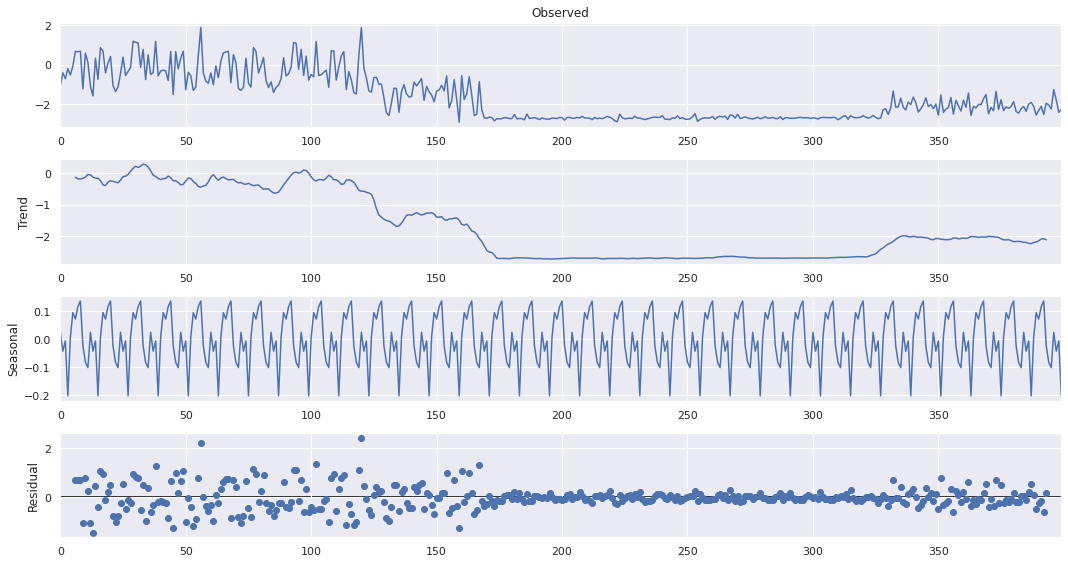

In [ ]:
#seasonal_decompose decomposition method

sns.set(rc={'figure.figsize':(15, 8)})
series = inputd[140]
result = seasonal_decompose(series, model='additive', freq = 12)
result.plot()
pyplot.show()
#print(result.trend)
#print(result.seasonal)
#print(result.resid)
#print(result.observed)

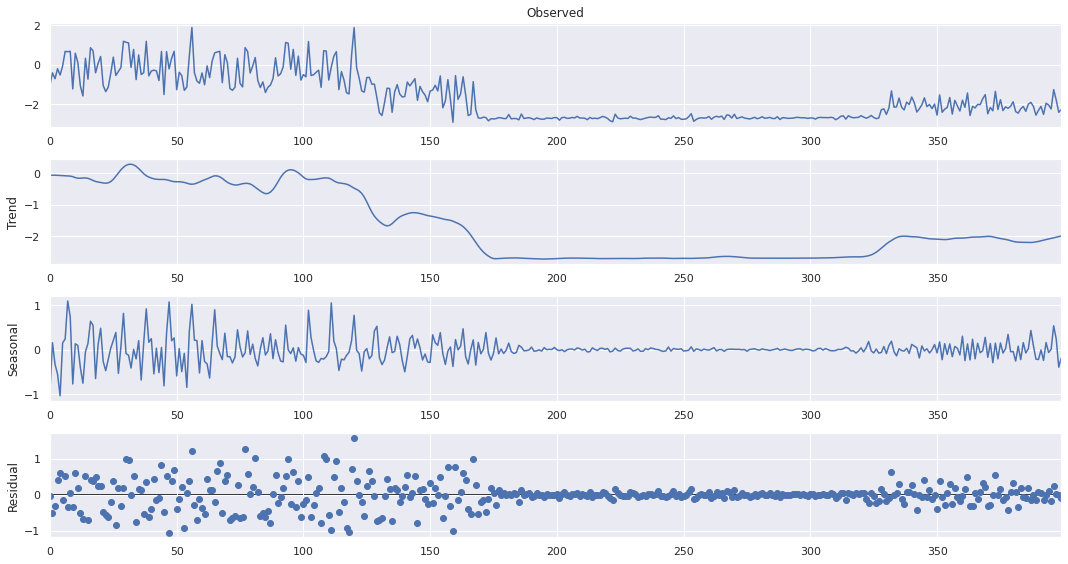

In [ ]:
#STL decomposition method
#Note: If this cell shows error, then run cell 2 and restart the kernel if it asks to do so.

sns.set(rc={'figure.figsize':(15, 8)})
series = inputd[140]
result = STL(series, period = 9) #  ,model='additive', freq=12
res = result.fit()
fig = res.plot()
#print(res.trend)
#print(res.seasonal)
#print(res.resid)

In [ ]:
#Now decomposing all the train input signal
input_ses = []
input_tr = []
input_res = []
for i in range(len(inputd)):
  series = inputd[i]
  result = STL(series, period = 9)
  res = result.fit()
  input_ses.append(res.seasonal)
  input_tr.append(res.trend)
  input_res.append(res.resid)
print(np.array(input_res).shape)

(700, 400)


In [ ]:
#Now decomposing all the test input signal

input_ses_test = []
input_tr_test = []
input_res_test = []
for i in range(len(inputd_test)):
  series = inputd_test[i]
  result = STL(series, period = 3)
  res = result.fit()
  input_ses_test.append(res.seasonal)
  input_tr_test.append(res.trend)
  input_res_test.append(res.resid)
print(np.array(input_res_test).shape)

(48, 400)


Now we are creating the input data for the model. Suppose we have the "forecast" library available in python, in such a case we can extract multiple seasonality and then we can use Seasonal Exogenous Approach (SE). To use the SE approch, we need to append the seasonality component in the input data of the model. For this include the seasonality component in the following two code cells (I have commented them because we have a lack of library here and we are also using DS approch).

In [ ]:
#Since we are using decomposition method (DS), we will not include the seasonality component in the input data.
inputd_new = []
#inputd_new.append(input_ses)  
inputd_new.append(input_tr)
inputd_new.append(input_res)
inputd_new = np.array(inputd_new)
inputd_new.shape

(2, 700, 400)

In [ ]:
inputd_new_test = []
#inputd_new_test.append(input_ses_test)
inputd_new_test.append(input_tr_test)
inputd_new_test.append(input_res_test)
inputd_new_test = np.array(inputd_new_test)
inputd_new_test.shape

(2, 48, 400)

In [ ]:
#Reshaping the data according to the input requirements of PyTorch

no = inputd_new.shape[1] #number of data arrays in train set
no2 = inputd_new.shape[2] #length of each data array in train set
ar_final = []
for i in range(no):
  unit = []
  for j in range(no2):
    unit.append(inputd_new[:,i,j])
    
  ar_final.append(unit)


no = inputd_new_test.shape[1] #number of data arrays in test set
no2 = inputd_new_test.shape[2] #length of each data array in test set
ar_final_test = []
for i in range(no):
  unit = []
  for j in range(no2):
    unit.append(inputd_new_test[:,i,j])
    
  ar_final_test.append(unit)

In [ ]:
arrr = np.array(ar_final)
arrr.shape

(700, 400, 2)

In [ ]:
arrr_test = np.array(ar_final_test)
arrr_test.shape

(48, 400, 2)

### Implementation of Pytorch Model

In [ ]:
import torch
import os
from pylab import rcParams
from matplotlib import rc
from torch import nn, optim

In [ ]:
inputd_training = arrr[0:450]
inputd_testing = arrr[450:700]

outputd_training = outputd[0:450]
outputd_testing = outputd[450:700]

#Creating train set tensors
X_train = torch.from_numpy(inputd_training).float()
y_train = torch.from_numpy(outputd_training).float()

#Creating Validation set tensors
X_test = torch.from_numpy(inputd_testing).float()
y_test = torch.from_numpy(outputd_testing).float()

#print(y_train.shape)
#print(y_test.shape)

In [ ]:
class Predictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers):
    super(Predictor, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, dropout=0.4)
    
    self.linear = nn.Linear(in_features=n_hidden, out_features=n)  # Here n is the length of output feature defined in initial cells
  
  def reset_hidden_state(self):
    self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                   torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
  
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1),self.hidden)
    last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1] 
    y_pred = self.linear(last_time_step)
    return y_pred

I have defined the loss function used in the paper and also tuned the hyperparameter. I have also used MSE loss function to see the difference in the performance.
Although I have commented it in the "train_model" function. Just we need to equate the "loss" variable with the commented code, if we want to use the MSE loss function.

In [ ]:
def custom_loss(yt,yp):
  lmd = 0.05
  
  c_loss = torch.sum(torch.abs(yt-yp).float())
  l = torch.sum(model.linear.weight**2)
  a = torch.sum(model.lstm._parameters['weight_ih_l0']**2)
  b = torch.sum(model.lstm._parameters['weight_ih_l1']**2)
  c = torch.sum(model.lstm._parameters['weight_ih_l2']**2)
  c_loss2 = (1/yt.shape[0])*(c_loss + (lmd*(a + b + c + l)))  
  return c_loss2

In [ ]:
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None ):
  
  loss_fn = nn.MSELoss() 
  optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
  num_epochs = 90
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  
  for t in range(num_epochs):
    model.reset_hidden_state()
    y_pred = model(X_train)
    loss = custom_loss(y_pred.float(), y_train) #loss_fn(y_pred.float(), y_train) 
    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = custom_loss(y_test_pred.float(), y_test) #loss_fn(y_test_pred.float(), y_test) 
      test_hist[t] = test_loss.item()
      if t % 5 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 5 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')
    train_hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  return model.eval(), train_hist, test_hist

In [ ]:
seq_length = m # Here m is the length of the input feature defined in initial cells

model = Predictor(n_features=2, n_hidden=40, seq_len=seq_length, n_layers=3)     #In case of decomposed signal n_features parameter will be more than one 
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)

Epoch 0 train loss: 25.994211196899414 test loss: 26.38738250732422
Epoch 5 train loss: 25.492786407470703 test loss: 25.866302490234375
Epoch 10 train loss: 24.757030487060547 test loss: 25.086641311645508
Epoch 15 train loss: 23.16783905029297 test loss: 23.36379623413086
Epoch 20 train loss: 19.65247917175293 test loss: 19.784095764160156
Epoch 25 train loss: 15.212027549743652 test loss: 15.447613716125488
Epoch 30 train loss: 11.85921573638916 test loss: 12.07269287109375
Epoch 35 train loss: 9.231280326843262 test loss: 9.39694881439209
Epoch 40 train loss: 7.3137383460998535 test loss: 7.371264934539795
Epoch 45 train loss: 6.053480625152588 test loss: 6.023776531219482
Epoch 50 train loss: 5.163895130157471 test loss: 5.068870544433594
Epoch 55 train loss: 4.484210014343262 test loss: 4.452426433563232
Epoch 60 train loss: 4.037544250488281 test loss: 4.033502101898193
Epoch 65 train loss: 3.993082046508789 test loss: 3.9502780437469482
Epoch 70 train loss: 3.9923713207244873 t

In [ ]:
#Details of our model
print(model.eval())
repr(model)

Predictor(
  (lstm): LSTM(2, 40, num_layers=3, dropout=0.4)
  (linear): Linear(in_features=40, out_features=13, bias=True)
)


'Predictor(\n  (lstm): LSTM(2, 40, num_layers=3, dropout=0.4)\n  (linear): Linear(in_features=40, out_features=13, bias=True)\n)'

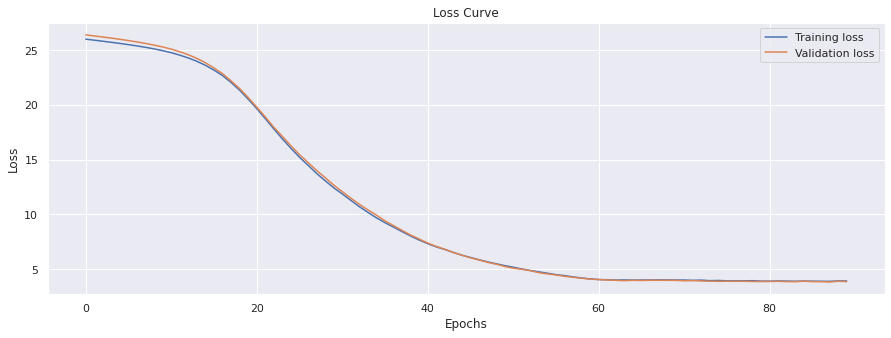

In [ ]:
sns.set(rc={'figure.figsize':(15, 5)})
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Validation loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [ ]:
tester = torch.from_numpy(arrr_test).float()
yts = outputd_test
y_test_pred = model(tester)
#y_test_pred[0].shape

In [ ]:
#In case we have to use the MSE loss function then equate the following equations with the commented code.
'''
loss_fn = nn.MSELoss() 
loss = loss_fn(y_test_pred, torch.from_numpy(yts))
print("Loss of the test set:",loss.detach().numpy())   
'''
loss_fn = custom_loss(y_test_pred.float(), torch.from_numpy(yts).float())  
loss = loss_fn
print("Loss of the test set:",loss.detach().numpy())   

Loss of the test set: 3.2563887


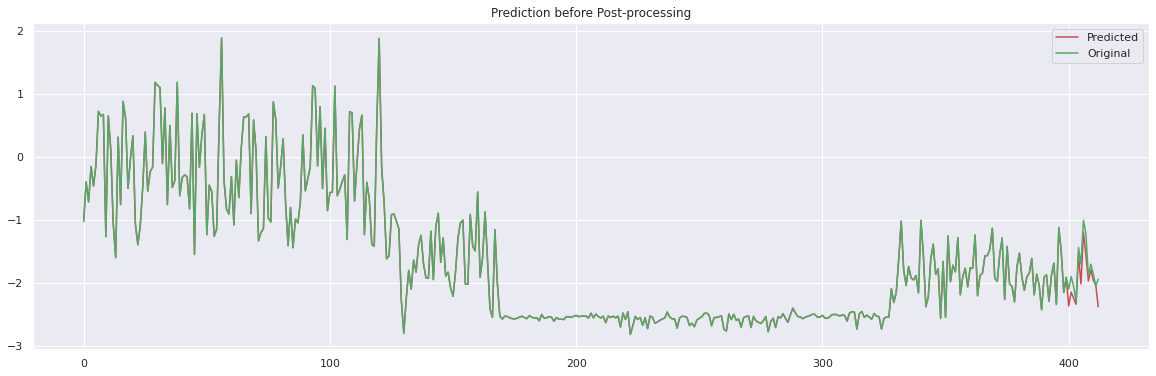

In [ ]:
n_test = 41   # There are 48 test examples. Put the value of n_test based on the example to predict. 
inital = np.concatenate((inputd_test[n_test],yts[n_test]), axis=None)
final = np.concatenate((inputd_test[n_test], y_test_pred[n_test].detach().numpy()), axis=None)

sns.set(rc={'figure.figsize':(20, 6)})
plt.plot(final[:], label="Predicted", color = "r" )
plt.plot(inital[:], label="Original", color = "g" )
plt.title("Prediction before Post-processing")
plt.legend();

In the following code cell we have defined a fuction for post processing of data i.e.; reseasonalisation and renormalisation.

In [ ]:
def postprocess(input):
  inputd_test2 = []
  for i in range(len(input)):
    if input[i] > 0:
        inputd_test2.append(10**input[i]) 
    elif input[i] < 0:
        inputd_test2.append(10**input[i])
    else:
        inputd_test2.append(0)

  inputd_test3 = np.array(inputd_test2)*((1/len(inputd_test2))*(df_test_m_final.reset_index()["V"+str(n_test+1)].sum()))
  return (inputd_test3)

Now we will plot the predicted and original time series from test dataset.

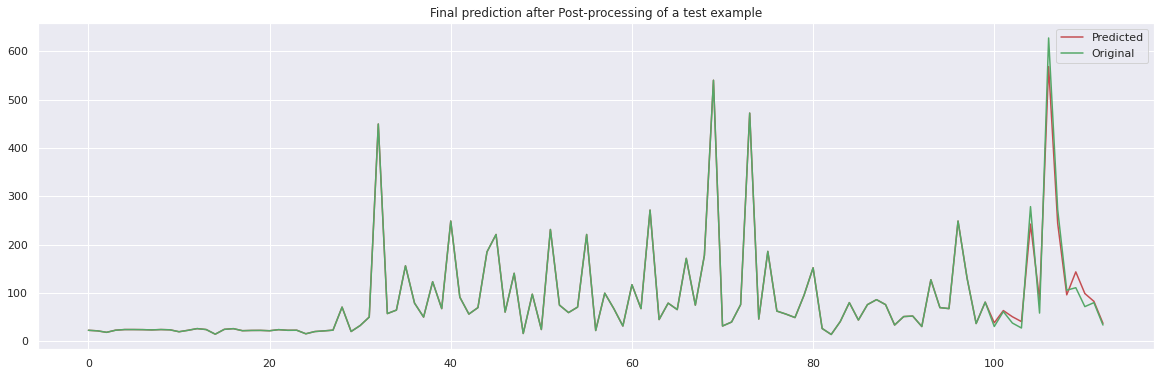

In [ ]:
n_test = 20   # There are 48 test examples. Put the value of n_test based on the example to predict. 
inital = np.concatenate((inputd_test[n_test],yts[n_test]), axis=None)
final = np.concatenate((inputd_test[n_test], y_test_pred[n_test].detach().numpy()), axis=None)

Initial = postprocess(inital)
Final = postprocess(final)

sns.set(rc={'figure.figsize':(20, 6)})
plt.plot(Final[300:], label="Predicted", color = "r")
plt.plot(Initial[300:], label="Original", color = "g" )
plt.title("Final prediction after Post-processing of a test example")
plt.legend();

### Model's performance evaluation on test data (sMAPE)

In [ ]:
def smape(I, F):
    return (2/len(I))*np.sum(2*np.abs(F - I) / (np.abs(I) + np.abs(F)))

#print(smape(Initial[400:], Final[400:]))

In [ ]:
sMAPE = []
for i in range(df_test_m.shape[1]):
  n_test = i   # There are 48 test examples. Put the value of n_test based on the example to predict. 
  in_i = yts[n_test]
  fin_i = y_test_pred[n_test].detach().numpy()
  sMAPE.append(smape(in_i, fin_i))
sMAPE = np.array(sMAPE)

In [ ]:
print("The mean of sMAPE is", sMAPE.mean())
print("The median of sMAPE is", np.median(sMAPE))

The mean of sMAPE is 0.25129803928443084
The median of sMAPE is 0.2170162993302115
